In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize, Bounds

In [3]:
def model(X,beta = None):
    if beta is None:
        beta = np.array([1.5,0.3,-0.08,-1,0.6])
    return np.sin(np.dot(beta[0],X[:,0]))+np.power((beta[1]*X[:,1]),1) + (X[:,2]**2-beta[2]) + beta[3]* np.log(X[:,3]) + np.power(np.sin(X[:,4]),beta[4])

In [4]:
rng = np.random.RandomState(123)
X = rng.rand(1000, 5)
Y = model(X)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) # Generating train and test dataset

Cobyla with co and with epochs

In [5]:

class non_linear():
    def __init__(self,alpha,epochs = 1000,tol=1e-6):  
        self.alpha = alpha 
        self.epochs = epochs
        self.tol = tol
        self.coef_c = None   
        self.coef_l = None 
        self.coef_n = None 
    
    def loss(self,beta_j,X,Y,beta,j):  
        beta[j] = beta_j
        loss = (0.5/X.shape[0])* np.linalg.norm(Y- model(X,beta),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        np.random.seed(123)
        beta_l =np.random.rand(X.shape[1]) #np.ones(X.shape[1])                      
        beta_n =np.random.rand(X.shape[1])
        beta_c =np.random.rand(X.shape[1])

        for iter in range(self.epochs): 
            beta_old_l = np.copy(beta_l)  
            beta_old_n = np.copy(beta_n)  
            beta_old_c = np.copy(beta_c)           
            
            for j in range(len(beta_l)):  

                options = {'maxiter': 1000000}                                      
                                            
                res_l = minimize(self.loss, x0=beta_l[j],args=(X,Y,beta_l,j), method='L-BFGS-B',jac = False, 
                               options=options,tol=1e-8)
                res_n = minimize(self.loss, x0=beta_n[j],args=(X,Y,beta_n,j), method='Nelder-Mead',jac = False, 
                               options=options,tol=1e-8)
                res_c = minimize(self.loss, x0=beta_c[j],args=(X,Y,beta_c,j), method='COBYLA',jac = False, 
                               options=options,tol=1e-8)
                                    
                beta_l[j] = (self.soft_threshold(res_l.x,1e-4))
                beta_n[j] = (self.soft_threshold(res_n.x,1e-4))
                beta_c[j] = (self.soft_threshold(res_c.x,1e-4))
                #print("Iterations: ", res.nfev)

            if np.linalg.norm(beta_l - beta_old_l) < self.tol:
                print("Optimization converged after l", iter+1, "iterations")
                break  
            if np.linalg.norm(beta_n - beta_old_n) < self.tol:
                print("Optimization converged after n", iter+1, "iterations")
                break 
            if np.linalg.norm(beta_c - beta_old_c) < self.tol:
                print("Optimization converged after c", iter+1, "iterations")
                break      
                
        self.coef_c = beta_c
        self.coef_l = beta_l
        self.coef_n = beta_n
            
        return self
    
    def predict(self, X):
        y_l = model(X,self.coef_l)
        y_n = model(X,self.coef_n)
        y_c = model(X,self.coef_c)
                
        return y_l,y_n,y_c
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))
    

In [6]:
lamda = [0,0.0001,0.001,0.01,0.1,1,10]

Time: 1.06 sec(1000) 10^5-1:5 10^6-1:12.8

In [7]:
test_loss = []
wo_c = np.zeros((len(lamda),X.shape[1]))
wo_l = np.zeros((len(lamda),X.shape[1]))
wo_n = np.zeros((len(lamda),X.shape[1]))

Nr_c = []
Nr_l = []
Nr_n = []

for i,val in enumerate(lamda):
    opt_cb = non_linear(val)
    opt_cb.fit(X_train,Y_train)    
    wo_c[i,:] = opt_cb.coef_c
    wo_l[i,:] = opt_cb.coef_l
    wo_n[i,:] = opt_cb.coef_n
    y_l,y_n,y_c = opt_cb.predict(X_test)
    #test_loss.append((tf.keras.losses.mae(yp, Y_test)).numpy())
    Nr_c.append(opt_cb.NRMSE(Y_test,y_c))
    Nr_l.append(opt_cb.NRMSE(Y_test,y_l))
    Nr_n.append(opt_cb.NRMSE(Y_test,y_n))

Optimization converged after l 137 iterations
Optimization converged after l 135 iterations
Optimization converged after l 125 iterations
Optimization converged after l 76 iterations
Optimization converged after n 44 iterations
Optimization converged after n 4 iterations
Optimization converged after l 2 iterations


In [8]:
print(Nr_c)
print(Nr_l)
print(Nr_n)

[0.00037262332125450747, 0.0011593270969251712, 0.008940081764742869, 0.059053842241776025, 0.25491444571417865, 0.662393918826126, 1.4349221176874947]
[0.00034262567758128594, 0.0011269956156440375, 0.008911922123164448, 0.059015360544297665, 0.2549171613419834, 0.6623939131538072, 1.4349221176874947]
[0.1837421586196018, 0.0011593249362708384, 0.008940114862863863, 0.05905392390531879, 0.2549144808381759, 0.6623939080471939, 1.4349221176874947]


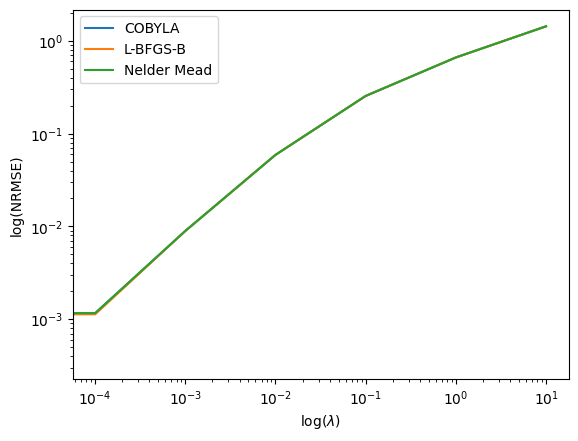

In [9]:
plt.plot(lamda,Nr_c,label='COBYLA')
plt.plot(lamda,Nr_l,label='L-BFGS-B')
plt.plot(lamda,Nr_n,label='Nelder Mead')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

GD

In [10]:
def model_tf(X,beta):
    X  = tf.cast(X, dtype='float32')
    if beta is None:
        beta = tf.Variable([1.5,0.3,-0.08,-1,0.6])
    return tf.sin(( X[:, 0]*beta[0])) + tf.pow((beta[1] * X[:, 1]), 1) + (tf.pow(X[:, 2], 2) - beta[2]) + (beta[3] * tf.math.log(X[:, 3])) + tf.pow(tf.sin(X[:, 4]), beta[4])

In [11]:
def run_gradient_descent(X, Y,learning_rate,lam ,epochs = 10000):
   init_slope = np.ones(X.shape[1])
   tf_slope = tf.Variable(init_slope, dtype='float32') 

   def soft_threshold(rho,lamda):
        rho_np = rho.numpy()
        if np.all(rho_np < -lamda):
            return rho + lamda
        elif np.all(rho_np > lamda):
            return rho - lamda
        else:
            return tf.zeros_like(rho)

   for i in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(tf_slope)

            # This is the same mean-squared-error calculation as before
            X_r  = tf.cast(X, dtype='float32')
            #pred = tf.cast (model(X_float32,tf_slope),dtype= 'float32')
            Y_reshaped = tf.cast(tf.reshape(Y, (-1, 1)), dtype='float32')         
            
            loss = (0.5 / X.shape[0]) * tf.norm(tf.transpose(Y_reshaped)- model_tf(X_r,tf_slope),ord=2)**2 + lam * tf.norm(tf_slope, ord=1)        
            

        # Auto-diff magic!  Calcs gradients between loss calc and params
        dloss_dparams = tape.gradient(loss, tf_slope)        
        # Gradients point towards +loss, so subtract to "descend"
        tf_slope.assign_sub(learning_rate * dloss_dparams)
        #tf_slope.assign(soft_threshold(tf_slope, 1e-3))
        
        
        
   return tf_slope

def NRMSE(y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [12]:
wo_gd = run_gradient_descent(X_train, Y_train, 0.1,0,epochs=10000)    
yp_gd = model_tf(X_test,wo_gd)
#test_loss.append((tf.keras.losses.mae(yp, Y_test)).numpy())
NR_gd = (NRMSE(Y_test,yp_gd))

In [13]:

Nr_gd = []
for i in lamda:
    wo_gd = (run_gradient_descent(X_train, Y_train, 0.1,i,epochs=3000))    
    print(wo_gd)
    yp_gd = model_tf(X_test,wo_gd)
    #test_loss.append((tf.keras.losses.mae(yp, Y_test)).numpy())
    Nr_gd.append((NRMSE(Y_test,yp_gd)))

<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 1.4971452 ,  0.2998684 , -0.08085249, -0.99997795,  0.6000901 ],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 1.4907309 ,  0.29936567, -0.07993877, -0.99997294,  0.5937566 ],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 1.4356252 ,  0.2947498 , -0.07438999, -0.99993825,  0.5450462 ],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 1.1274275 ,  0.24666184, -0.07481423, -1.0003384 ,  0.33370644],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 0.41424412,  0.01205839, -0.14443615, -1.0042963 ,  0.00941742],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([ 0.126966  ,  0.10854442, -0.10789251, -0.62932247, -0.02541009],
      dtype=float32)>
<tf.Variable 'Variable:0' shape=(5,) dtype=float32, numpy=
array([7.6099396e

COBYLA without co

In [14]:
np.random.seed(123)
class non_linear_all():
    def __init__(self,alpha,epochs = 1000):  
        self.alpha = alpha 
        self.epochs = epochs
        self.coef = None   
      
    def loss(self,beta,X,Y):       
        loss = (0.5/X.shape[0])* np.linalg.norm((Y- model(X,beta)),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho.all() < - lamda:
            return rho + lamda
        elif rho.all() > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        beta_l =np.random.rand(X.shape[1]) #np.ones(X.shape[1])                      
        beta_n =np.random.rand(X.shape[1])
        beta_c =np.random.rand(X.shape[1])  #np.ones(X.shape[1])                   

        options = {'maxiter': 100000,'disp':True}                                      
                                                            
        res_c = minimize(self.loss, x0=beta_c,args=(X,Y), method='COBYLA',jac = False, options=options,tol=1e-8)
        res_l = minimize(self.loss, x0=beta_l,args=(X,Y), method='L-BFGS-B',jac = False, options=options,tol=1e-8)
        res_n = minimize(self.loss, x0=beta_n,args=(X,Y), method='Nelder-Mead',jac = False, options=options,tol=1e-8)
                                                    
        beta_c = (self.soft_threshold(res_c.x,1e-5))
        beta_l = (self.soft_threshold(res_l.x,1e-5))
        beta_n = (self.soft_threshold(res_n.x,1e-5))
        print("Iterations c: ", res_c.nfev) 
        print("Iterations l: ", res_l.nfev)
        print("Iterations n: ", res_n.nfev)
            #print(beta)
                    
                
        self.coef_c = beta_c
        self.coef_l = beta_l
        self.coef_n = beta_n   
        return self
    
    def predict(self, X):
        y_c = model(X,self.coef_l)
        y_l = model(X,self.coef_n)
        y_n = model(X,self.coef_c)
                
        return y_l,y_n,y_c
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

1000-0.3  10^4 - 2.6  10^5: 23.1 10^6- 5:8.3

In [15]:
test_loss_all = []
wo_c_all = np.zeros((len(lamda),X.shape[1]))
wo_l_all = np.zeros((len(lamda),X.shape[1]))
wo_n_all = np.zeros((len(lamda),X.shape[1]))
Nr_c_all = []
Nr_l_all = []
Nr_n_all = []

for i,val in enumerate(lamda):
    opt_cb = non_linear_all(val)
    opt_cb.fit(X_train,Y_train)    
    wo_c_all[i,:] = opt_cb.coef_c
    wo_l_all[i,:] = opt_cb.coef_l
    wo_n_all[i,:] = opt_cb.coef_n
    y_l_all,y_n_all,y_c_all = opt_cb.predict(X_test)
    #test_loss_all.append((tf.keras.losses.mae(yp_all, Y_test)).numpy())
    Nr_c_all.append(opt_cb.NRMSE(Y_test,y_c_all))
    Nr_l_all.append(opt_cb.NRMSE(Y_test,y_l_all))
    Nr_n_all.append(opt_cb.NRMSE(Y_test,y_n_all))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 434
         Function evaluations: 708
Iterations c:  4476
Iterations l:  132
Iterations n:  708
Optimization terminated successfully.
         Current function value: 0.000347
         Iterations: 441
         Function evaluations: 736
Iterations c:  4145
Iterations l:  114
Iterations n:  736
Optimization terminated successfully.
         Current function value: 0.003413
         Iterations: 516
         Function evaluations: 842
Iterations c:  3925
Iterations l:  132
Iterations n:  842
Optimization terminated successfully.
         Current function value: 0.030545
         Iterations: 526
         Function evaluations: 859
Iterations c:  45663
Iterations l:  120
Iterations n:  859
Optimization terminated successfully.
         Current function value: 0.212783
         Iterations: 634
         Function evaluations: 1028
Iterations c:  296
Iterations l:  678
Iterations n:  1028
Optimiza

In [16]:
print(Nr_c_all)
print(Nr_l_all)
print(Nr_n_all)

[1.4213091790621237e-05, 0.0009145058311794982, 0.008795894076251908, 0.058951495288163465, 0.25482818974433297, 0.6623454037750065, 1.4349053932294267]
[1.603861503131215e-05, 0.0009349245883601125, 0.008789486252896956, 0.05895208025717413, 0.23507880741992696, 0.8519070213200216, 1.3262564489018973]
[1.6014925887920864e-05, 0.0009348595739241801, 0.008789396837542105, 0.05895203786704677, 0.2572084126125404, 0.7359921290172322, 1.4349102453549425]


In [17]:
print(Nr_c_all)
print(Nr_gd)

[1.4213091790621237e-05, 0.0009145058311794982, 0.008795894076251908, 0.058951495288163465, 0.25482818974433297, 0.6623454037750065, 1.4349053932294267]
[0.0002457843246617113, 0.0010830362933984183, 0.008843669952091265, 0.05894560476212654, 0.25377187402956153, 0.6003200176617616, 2.3833430019450255]


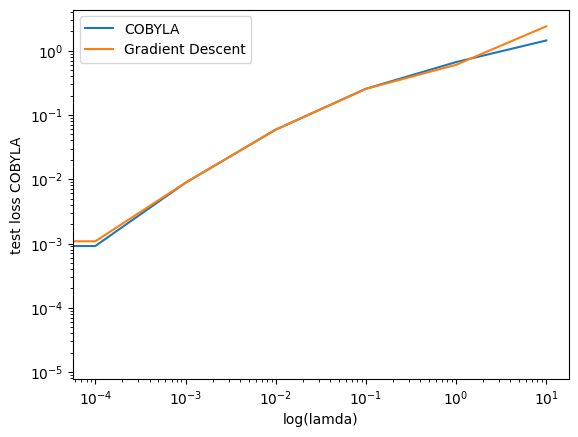

In [22]:
plt.plot(lamda,Nr_c_all,label='COBYLA')
plt.plot(lamda,Nr_gd,label='Gradient Descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss COBYLA')
plt.legend()
plt.show()

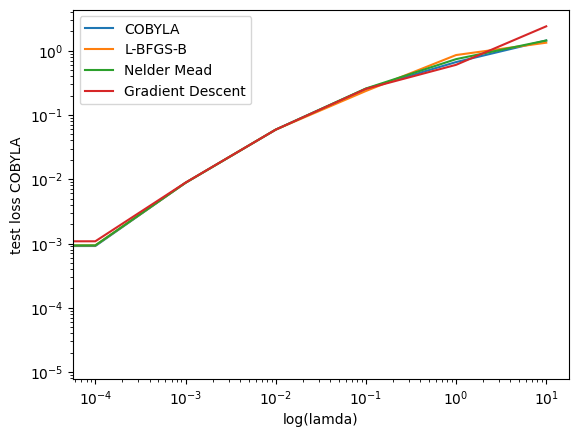

In [23]:
plt.plot(lamda,Nr_c_all,label='COBYLA')
plt.plot(lamda,Nr_l_all,label='L-BFGS-B')
plt.plot(lamda,Nr_n_all,label='Nelder Mead')
plt.plot(lamda,Nr_gd,label='Gradient Descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss COBYLA')
plt.legend()
plt.show()

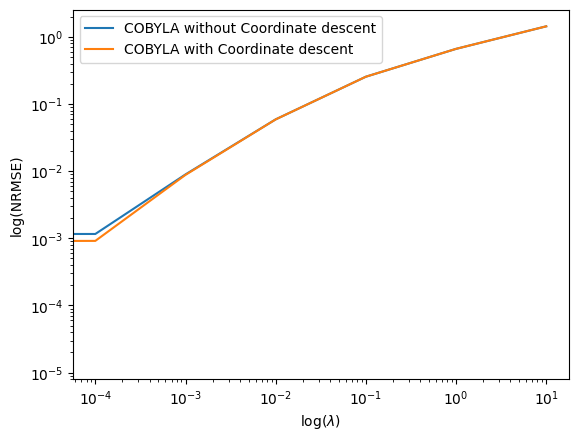

In [19]:
plt.plot(lamda,Nr_c,label='COBYLA without Coordinate descent')
plt.plot(lamda,Nr_c_all,label='COBYLA with Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

l-BFGS-B

In [20]:
mu=0.0
std = 0.40 * np.std(Y) # for %20 Gaussian noise
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_n = x + noise
    return x_n 

Yn_train = gaussian_noise(Y_train,mu,std)

In [21]:
test_loss_no = []
wo_cb_no = np.zeros((len(lamda),X.shape[1]))

for i,val in enumerate(lamda):
    opt_cb = non_linear(val,epochs=1000)
    opt_cb.fit(X_train,Yn_train)    
    wo_cb_no[i,:] = opt_cb.coef
    yp = opt_cb.predict(X_test)
    test_loss_no.append((tf.keras.losses.mae(yp, Y_test)).numpy())

Optimization converged after l 148 iterations


AttributeError: 'non_linear' object has no attribute 'coef'

In [ ]:
print(test_loss)
print(test_loss_no)

[0.007583449375444786, 0.007673178711728765, 0.008547249745899783, 0.019617195925502467, 0.044889583145642745, 0.2625389195223943, 2.4222122801996164]
[0.7095300489559301, 0.7094136096171288, 0.7083658278893412, 0.6979911025286885, 0.5995060567939933, 0.5647364010144668, 2.538885782847022]
[[ 0.          0.29982092  0.07391685 -1.00004916 -0.5995355 ]
 [ 0.          0.29981931  0.07351965 -1.00005065 -0.5995804 ]
 [ 0.          0.29980503  0.06996104 -1.00006389 -0.59998363]
 [ 0.          0.29966213  0.03438203 -1.00019587 -0.60401473]
 [ 0.          0.2993268   0.         -0.99666618 -0.60428547]
 [ 0.          0.29708546  0.         -0.95612112 -0.56496123]
 [ 0.          0.26208854  0.         -0.02439733 -0.27513457]]


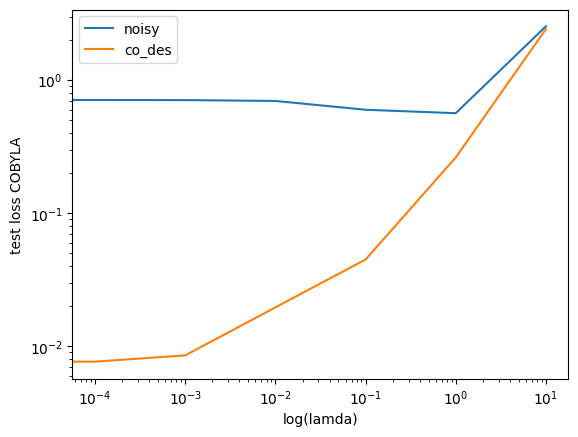

In [ ]:
plt.plot(lamda,test_loss_no,label = 'noisy')
plt.plot(lamda,test_loss,label = 'co_des')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss COBYLA')
plt.legend()
plt.show()